In [ ]:
!pip3 install torch torchvision matplotlib


In [1]:
from torchvision import datasets
#ToTensor takes images and turns it into tensors
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
train_data = dataset = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transform,
    download = True
)
test_data = dataset = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform,
    download = True
)

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [22]:
test_data.targets.size()

torch.Size([10000])

In [7]:
train_data.targets.size()

torch.Size([60000])

In [8]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
## load the data in batches , shuffle it ..
from torch.utils.data import  DataLoader
loaders = {
    'train' : DataLoader(train_data,
                         batch_size = 100,
                         shuffle = True,
                         num_workers = 1),
    'test' : DataLoader(test_data,
                         batch_size = 100,
                         shuffle = True,
                         num_workers = 1)
}

In [10]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e9834411660>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e98344116f0>}

In [11]:
## define the model architecture
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):

    def __init__(self):
        super(CNN,self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50,10)

    #forward function to define the activations
    def forward(self , x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #flatten the data
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)




In [12]:
## optimize the model
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
#define the Adam's optimizer
optimizer = optim.Adam(model.parameters(), lr= 0.001)
#define the loss function
loss_fn = nn.CrossEntropyLoss()

#the training process
def train(epoch):
    model.train()
    for batch_index , (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        #set the gradient to zero
        optimizer.zero_grad()
        output = model(data)
        #calculate the loss
        loss = loss_fn(output, target)
        #store gradients and optimize
        loss.backward()
        optimizer.step()
        if batch_index % 20 == 0:
            print(f'Train epoch : {epoch} [{batch_index * len(data)}/{len(loaders["train"].dataset)}({100. * batch_index / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')


def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device) , target.to(device)
            output = model(data)
            test_loss = loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\n Test set: average loss: {test_loss:.4f}, accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)\n')


In [13]:
for epoch in range(1, 11):
  train(epoch)
  test()

<ipython-input-11-e5540904cc6b>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train epoch : 1 [0/60000(0%)]	2.301219
Train epoch : 1 [2000/60000(3%)]	2.285831
Train epoch : 1 [4000/60000(7%)]	2.117375
Train epoch : 1 [6000/60000(10%)]	1.999788
Train epoch : 1 [8000/60000(13%)]	1.898393
Train epoch : 1 [10000/60000(17%)]	1.915320
Train epoch : 1 [12000/60000(20%)]	1.922841
Train epoch : 1 [14000/60000(23%)]	1.851472
Train epoch : 1 [16000/60000(27%)]	1.772724
Train epoch : 1 [18000/60000(30%)]	1.706515
Train epoch : 1 [20000/60000(33%)]	1.678749
Train epoch : 1 [22000/60000(37%)]	1.733076
Train epoch : 1 [24000/60000(40%)]	1.698937
Train epoch : 1 [26000/60000(43%)]	1.676230
Train epoch : 1 [28000/60000(47%)]	1.683993
Train epoch : 1 [30000/60000(50%)]	1.711829
Train epoch : 1 [32000/60000(53%)]	1.639801
Train epoch : 1 [34000/60000(57%)]	1.680145
Train epoch : 1 [36000/60000(60%)]	1.635447
Train epoch : 1 [38000/60000(63%)]	1.665829
Train epoch : 1 [40000/60000(67%)]	1.652322
Train epoch : 1 [42000/60000(70%)]	1.636632
Train epoch : 1 [44000/60000(73%)]	1.638357

In [14]:
def evalute(img_index):
  model.eval()
  data, target = test_data[img_index]
  data = data.unsqueeze(0).to(device)
  output = model(data)
  prediction = output.argmax(dim=1, keepdim=True)
  print(f'Prediction: {prediction.item()}, Actual: {target}')
  image = data.squeeze(0).squeeze(0).cpu().numpy()
  plt.imshow(image, cmap='gray')
  plt.show()

Prediction: 7, Actual: 7


<ipython-input-11-e5540904cc6b>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


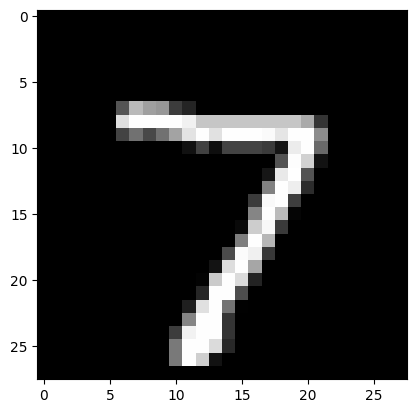

In [16]:
evalute(0)

<ipython-input-11-e5540904cc6b>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 0, Actual: 0


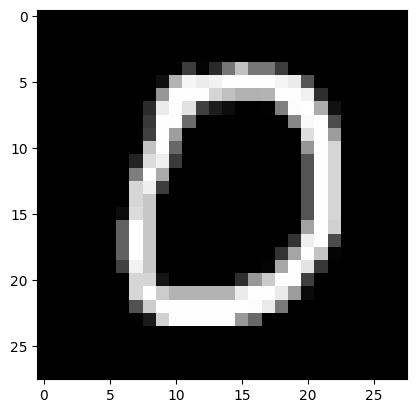

In [17]:
evalute(10)

Prediction: 1, Actual: 1


<ipython-input-11-e5540904cc6b>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


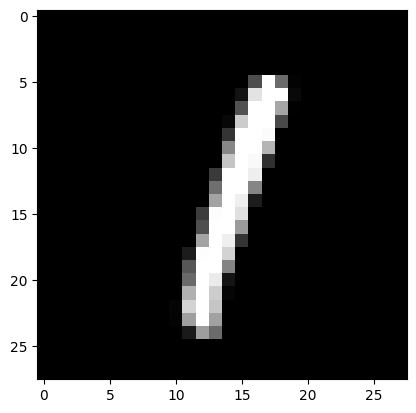

In [18]:
evalute(5)

<ipython-input-11-e5540904cc6b>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


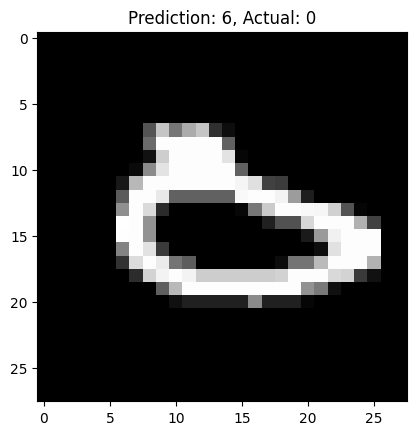

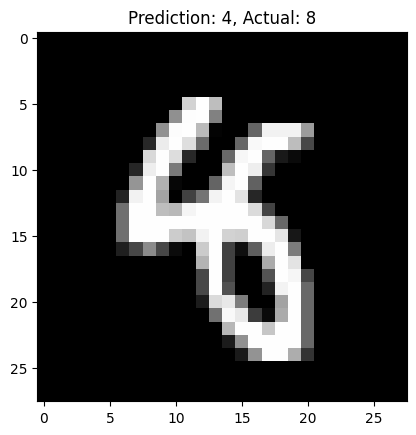

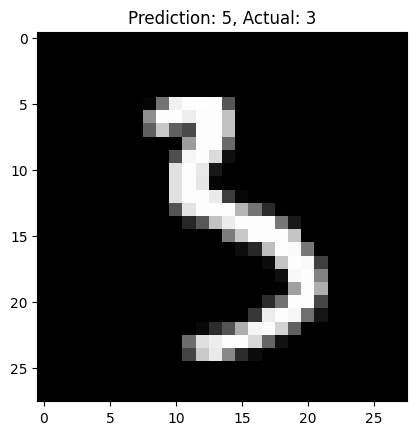

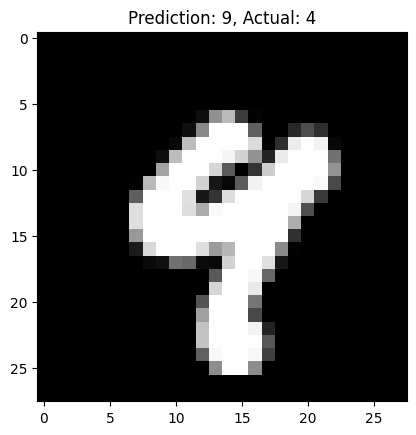

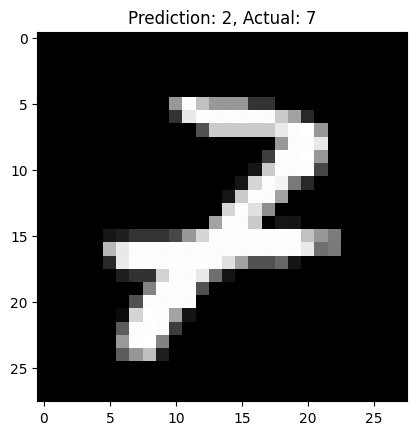

In [21]:
def evaluate_false_predictions(model, test_loader):
    model.eval()
    incorrect_images = []

    # Loop through the test loader to get the data and predictions
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        # Check for incorrect predictions
        incorrect_indices = (pred != target.view_as(pred)).nonzero(as_tuple=True)[0]
        i = 0
        # Collect incorrect images and their info
        for idx in incorrect_indices:
            incorrect_images.append((data[idx], target[idx], pred[idx]))
            i += 1  # Increment after collecting each incorrect image
            if i >= 5:  # Stop after collecting 5 incorrect images
                break
        if i >= 5:
            break

    # Display the incorrect predictions
    for img, actual, predicted in incorrect_images:
        img = img.squeeze(0).cpu().numpy()  # Convert the image to numpy array for display
        plt.imshow(img, cmap='gray')
        plt.title(f'Prediction: {predicted.item()}, Actual: {actual.item()}')
        plt.show()

evaluate_false_predictions(model, loaders['test'])
